In [2]:
from msresist.validations import preprocess_ebdt_mcf7
from msresist.clustering import MassSpecClustering
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from msresist.pca import plotPCA, plotPCA_scoresORloadings
from msresist.figures.figure2 import plotDistanceToUpstreamKinase

In [3]:
sns.set(style="whitegrid", font_scale=1, color_codes=True, palette="colorblind", rc={"grid.linestyle": "dotted", "axes.linewidth": 0.6})

In [7]:
# Import signaling data
x = preprocess_ebdt_mcf7()
d = x.select_dtypes(include=[float]).T
i = x.select_dtypes(include=[object])

# Fit DDMC and find centers
model = MassSpecClustering(i, ncl=20, SeqWeight=5, distance_method="Binomial", random_state=10).fit(d)
centers = pd.DataFrame(model.transform())
centers.columns = np.arange(model.n_components) + 1
centers.insert(0, "Inhibitor", x.columns[3:])
centers["Inhibitor"] = [s.split(".")[1].split(".")[0] for s in centers["Inhibitor"]]

# PCA AKT
AKTi = ["GSK690693", "Torin1", "HS173", "GDC0941", "Ku0063794", "AZ20", "MK2206", "AZD5363", "GDC0068", "AZD6738", "AT13148", "Edelfosine", "GF109203X", "AZD8055"]
centers["AKTi"] = [drug in AKTi for drug in centers["Inhibitor"]]

No handles with labels found to put in legend.


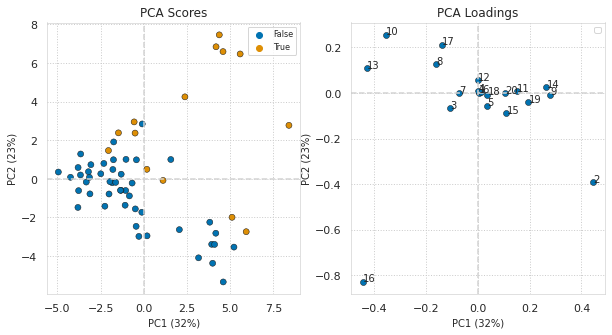

In [8]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
plotPCA(ax, centers, 2, ["Inhibitor", "AKTi"], "Cluster", hue_scores="AKTi")

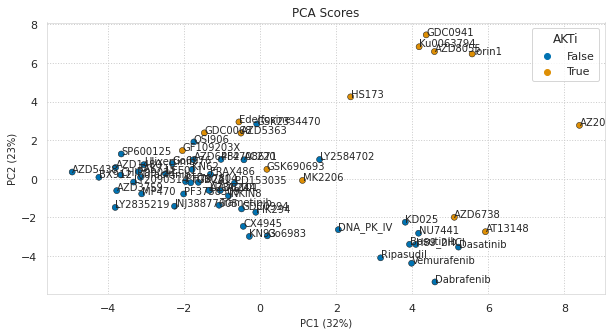

In [9]:
_, ax = plt.subplots(1, 1, figsize=(10, 5))
plotPCA_scoresORloadings(ax, centers, 2, ["Inhibitor", "AKTi"], "Cluster", hue_scores="AKTi", annotateScores=True)

/home/marcc/resistance-MS/msresist/clustering.py:181: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
/home/marcc/resistance-MS/msresist/clustering.py:181: RuntimeWarning: divide by zero encountered in log2
  pssm.loc[p_site, 5] = np.log2(clSeq.loc[p_site, 5] / tm)
No handles with labels found to put in legend.


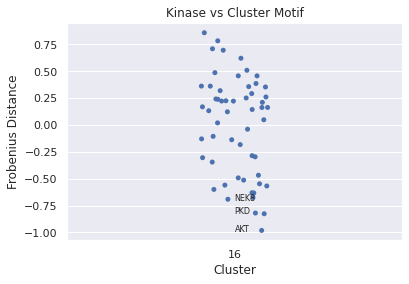

In [29]:
_, ax = plt.subplots(1, 1)
plotDistanceToUpstreamKinase(model, [16], ax=ax, num_hits=3)

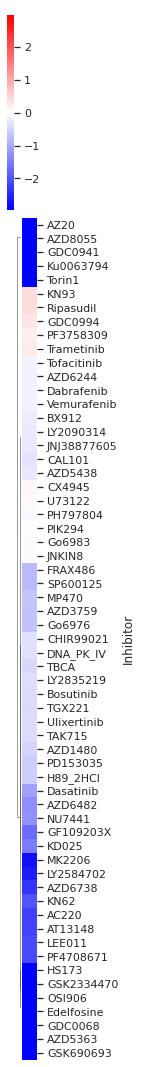

In [6]:
c1 = pd.DataFrame(model.transform()[:, 15])
X = pd.read_csv("msresist/data/Validations/Computational/ebdt_mcf7.csv")
index = [col.split("7.")[1].split(".")[0] for col in X.columns[2:]]
c1["Inhibitor"] = index
c1 = c1.set_index("Inhibitor")
lim = np.max(np.abs(c1)) * 0.3
g = sns.clustermap(c1, method="centroid", cmap="bwr", robust=True, vmax=lim, vmin=-lim, row_cluster=True, col_cluster=False, figsize=(2, 15), yticklabels=True, xticklabels=False)